In [1]:
from pathlib import Path
from datetime import datetime
import json
import pandas as pd

BASE_DIR = Path("data")   # root where your script is saving stuff


In [24]:
from pathlib import Path
from datetime import datetime
import json
import pandas as pd
import matplotlib.pyplot as plt

BASE_DIR = Path("data")

def list_runs(platform: str, base_dir: Path = BASE_DIR):
    plat_dir = base_dir / platform
    runs = []
    if not plat_dir.exists():
        return runs
    for date_dir in plat_dir.iterdir():
        if not date_dir.is_dir():
            continue
        date_str = date_dir.name
        for f in date_dir.glob("*.json"):
            stem = f.stem
            time_part, _, rest = stem.partition("_")
            test_type = rest.split("_")[-1] if rest else "unknown"
            dt = datetime.strptime(f"{date_str} {time_part}", "%Y-%m-%d %H-%M-%S")
            runs.append({
                "platform": platform,
                "date": date_str,
                "time": time_part,
                "test_type": test_type,
                "datetime": dt,
                "path": f
            })
    runs.sort(key=lambda x: x["datetime"], reverse=True)
    return runs

def get_latest_run(platform: str, test_type: str, base_dir: Path = BASE_DIR) -> Path:
    runs = list_runs(platform, base_dir=base_dir)
    for r in runs:
        if r["test_type"] == test_type:
            return r["path"]
    raise FileNotFoundError(f"No run found for {platform=} {test_type=}")

def load_k6_json(path: Path) -> pd.DataFrame:
    rows = []
    with path.open() as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            obj = json.loads(line)
            if obj.get("type") == "Point":
                metric = obj.get("metric")
                data = obj.get("data", {})
                value = data.get("value")
                tags = data.get("tags", {})
                rows.append({
                    "metric": metric,
                    "value": value,
                    **tags
                })
    return pd.DataFrame(rows)

TESTS = ["cold", "warm", "mixed"]
PLATFORMS = ["lambda", "fargate"]

def load_latest_all():
    datasets = {}
    for plat in PLATFORMS:
        for test in TESTS:
            try:
                p = get_latest_run(plat, test)
            except FileNotFoundError:
                continue
            df = load_k6_json(p)
            df["platform"] = plat
            df["test_type"] = test
            df["source_file"] = str(p)
            datasets[(plat, test)] = df
    return datasets

all_dfs = load_latest_all()



In [18]:
list_runs("lambda")[:5] 
#list_runs("fargate")[:5] if you want to see the files of fargate 


[{'platform': 'lambda',
  'date': '2025-11-02',
  'time': '21-15-02',
  'test_type': 'mixed',
  'datetime': datetime.datetime(2025, 11, 2, 21, 15, 2),
  'path': PosixPath('data/lambda/2025-11-02/21-15-02_lambda_mixed.json')},
 {'platform': 'lambda',
  'date': '2025-11-02',
  'time': '21-14-10',
  'test_type': 'cold',
  'datetime': datetime.datetime(2025, 11, 2, 21, 14, 10),
  'path': PosixPath('data/lambda/2025-11-02/21-14-10_lambda_cold.json')},
 {'platform': 'lambda',
  'date': '2025-11-02',
  'time': '21-13-53',
  'test_type': 'warm',
  'datetime': datetime.datetime(2025, 11, 2, 21, 13, 53),
  'path': PosixPath('data/lambda/2025-11-02/21-13-53_lambda_warm.json')}]

In [9]:
def get_latest_run(platform: str, test_type: str, base_dir: Path = BASE_DIR) -> Path:
    """
    Return the Path to the newest json file for e.g. ('lambda', 'warm')
    """
    runs = list_runs(platform, base_dir=base_dir)
    for r in runs:
        if r["test_type"] == test_type:
            return r["path"]
    raise FileNotFoundError(f"No run found for {platform=} {test_type=}")


In [10]:
latest_lambda_warm = get_latest_run("lambda", "warm")
latest_lambda_cold = get_latest_run("lambda", "cold")
latest_lambda_mixed = get_latest_run("lambda", "mixed")

latest_lambda_warm

PosixPath('data/lambda/2025-11-02/21-13-53_lambda_warm.json')

In [11]:
def load_k6_json(path: Path) -> pd.DataFrame:
    """
    Read a k6 JSON output file and return a DataFrame with metric rows.
    Each line is a JSON object.
    """
    rows = []
    with path.open() as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            obj = json.loads(line)
            # k6 writes different "type"s: 'Metric', 'Point', etc.
            if obj.get("type") == "Point":
                metric = obj.get("metric")
                data = obj.get("data", {})
                value = data.get("value")
                tags = data.get("tags", {})
                rows.append({
                    "metric": metric,
                    "value": value,
                    **tags
                })
    return pd.DataFrame(rows)


In [12]:
df_lambda_warm = load_k6_json(latest_lambda_warm)
df_lambda_warm.head()


,metric,value,expected_response,group,method,name,proto,scenario,status,tls_version,url,check
0,http_reqs,1.000,true,,GET,https://2jk7vovbx6.execute-api.eu-north-1.amaz...,HTTP/2.0,default,200,tls1.3,https://2jk7vovbx6.execute-api.eu-north-1.amaz...,NaN
1,http_req_duration,410.391,true,,GET,https://2jk7vovbx6.execute-api.eu-north-1.amaz...,HTTP/2.0,default,200,tls1.3,https://2jk7vovbx6.execute-api.eu-north-1.amaz...,NaN
2,http_req_blocked,196.638,true,,GET,https://2jk7vovbx6.execute-api.eu-north-1.amaz...,HTTP/2.0,default,200,tls1.3,https://2jk7vovbx6.execute-api.eu-north-1.amaz...,NaN
3,http_req_connecting,52.844,true,,GET,https://2jk7vovbx6.execute-api.eu-north-1.amaz...,HTTP/2.0,default,200,tls1.3,https://2jk7vovbx6.execute-api.eu-north-1.amaz...,NaN
4,http_req_tls_handshaking,84.746,true,,GET,https://2jk7vovbx6.execute-api.eu-north-1.amaz...,HTTP/2.0,default,200,tls1.3,https://2jk7vovbx6.execute-api.eu-north-1.amaz...,NaN


In [13]:
TESTS = ["cold", "warm", "mixed"]
PLATFORMS = ["lambda", "fargate"]

def load_latest_all():
    datasets = {}
    for plat in PLATFORMS:
        for test in TESTS:
            try:
                p = get_latest_run(plat, test)
            except FileNotFoundError:
                # maybe you didn't run that test yet
                continue
            df = load_k6_json(p)
            # keep some context
            df["platform"] = plat
            df["test_type"] = test
            df["source_file"] = str(p)
            datasets[(plat, test)] = df
    return datasets

all_dfs = load_latest_all()
all_dfs.keys()


dict_keys([('lambda', 'cold'), ('lambda', 'warm'), ('lambda', 'mixed'), ('fargate', 'cold'), ('fargate', 'warm'), ('fargate', 'mixed')])

In [14]:
combined = pd.concat(all_dfs.values(), ignore_index=True)
combined.head()


,metric,value,expected_response,group,method,name,proto,scenario,status,tls_version,url,check,platform,test_type,source_file
0,http_reqs,1.000,true,,GET,https://2jk7vovbx6.execute-api.eu-north-1.amaz...,HTTP/2.0,default,200,tls1.3,https://2jk7vovbx6.execute-api.eu-north-1.amaz...,NaN,lambda,cold,data/lambda/2025-11-02/21-14-10_lambda_cold.json
1,http_req_duration,67.786,true,,GET,https://2jk7vovbx6.execute-api.eu-north-1.amaz...,HTTP/2.0,default,200,tls1.3,https://2jk7vovbx6.execute-api.eu-north-1.amaz...,NaN,lambda,cold,data/lambda/2025-11-02/21-14-10_lambda_cold.json
2,http_req_blocked,125.568,true,,GET,https://2jk7vovbx6.execute-api.eu-north-1.amaz...,HTTP/2.0,default,200,tls1.3,https://2jk7vovbx6.execute-api.eu-north-1.amaz...,NaN,lambda,cold,data/lambda/2025-11-02/21-14-10_lambda_cold.json
3,http_req_connecting,56.826,true,,GET,https://2jk7vovbx6.execute-api.eu-north-1.amaz...,HTTP/2.0,default,200,tls1.3,https://2jk7vovbx6.execute-api.eu-north-1.amaz...,NaN,lambda,cold,data/lambda/2025-11-02/21-14-10_lambda_cold.json
4,http_req_tls_handshaking,67.443,true,,GET,https://2jk7vovbx6.execute-api.eu-north-1.amaz...,HTTP/2.0,default,200,tls1.3,https://2jk7vovbx6.execute-api.eu-north-1.amaz...,NaN,lambda,cold,data/lambda/2025-11-02/21-14-10_lambda_cold.json


In [15]:
def summarize_latency(df: pd.DataFrame) -> pd.DataFrame:
    # filter only http_req_duration points
    d = df[df["metric"] == "http_req_duration"]["value"]
    if d.empty:
        return pd.DataFrame()
    return pd.DataFrame({
        "count": [len(d)],
        "avg_ms": [d.mean()],
        "p90_ms": [d.quantile(0.90)],
        "p95_ms": [d.quantile(0.95)],
    })

summaries = []
for (plat, test), df in all_dfs.items():
    s = summarize_latency(df)
    if not s.empty:
        s["platform"] = plat
        s["test_type"] = test
        summaries.append(s)

summary_df = pd.concat(summaries, ignore_index=True)
summary_df


,count,avg_ms,p90_ms,p95_ms,platform,test_type
0,10,90.488700,109.5459,110.80995,lambda,cold
1,150,116.073947,112.6385,405.98105,lambda,warm
2,100,81.557850,104.4509,106.16230,lambda,mixed
3,10,80.751200,98.6677,100.18735,fargate,cold
4,150,85.152907,101.3966,106.78405,fargate,warm
5,100,201.355070,575.1295,724.04080,fargate,mixed


In [49]:
invocations = 314   # from CloudWatch
duration_ms = 290_000  # example from CW Sum(Duration)
memory_gb = 0.256   # 256 MB

requests_cost = invocations * 0.20 / 1_000_000
gb_seconds = (duration_ms / 1000) * memory_gb
compute_cost = gb_seconds * 0.0000166667
lambda_cost = requests_cost + compute_cost
lambda_cost


0.001300135808

In [54]:
vcpus = 0.5
mem_gb = 1
runtime_seconds = 12 * 60  # 12 minutes

price_vcpu = 0.04048     # adjust with eu-north-1 actual if needed
price_mem  = 0.004445

vCPU_hours = runtime_seconds / 3600 * vcpus
GB_hours   = runtime_seconds / 3600 * mem_gb

fargate_cost = vCPU_hours * price_vcpu + GB_hours * price_mem
fargate_cost 
#In this section am trying to calculate the cost during that time while the test was running ,
#i used date,time stamp to get the exact time while the test was running, n the still the container running
#it is a predicted cost , will be compared with if the cpu usage and memory usage during the test spikes any differenc in cost 
#So overall calculating the duration cost for fargate is seems little challange as compare to Lambda invocations cost 
#below calculate cost can be different according to situations and tasks

0.004937

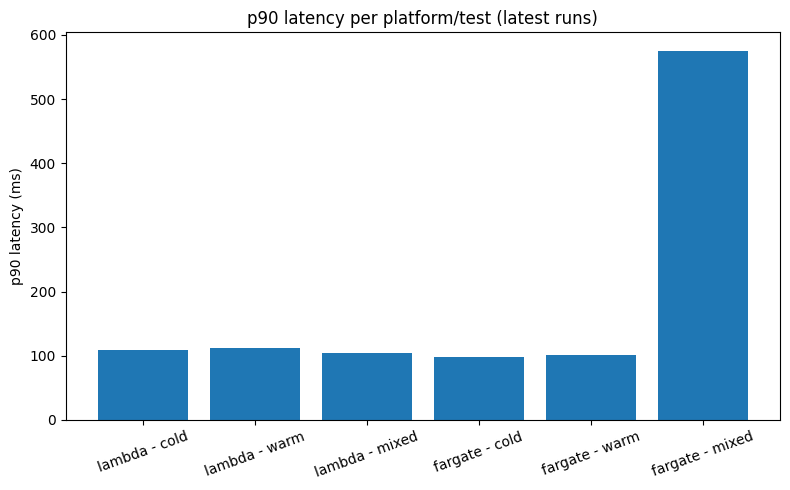

In [27]:
# make sure we have something
assert not summary_df.empty, "No data to plot."

# create a combined label like "lambda - warm"
summary_df["label"] = summary_df["platform"] + " - " + summary_df["test_type"]

plt.figure(figsize=(8, 5))
plt.bar(summary_df["label"], summary_df["p90_ms"])
plt.ylabel("p90 latency (ms)")
plt.title("p90 latency per platform/test (latest runs)")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()


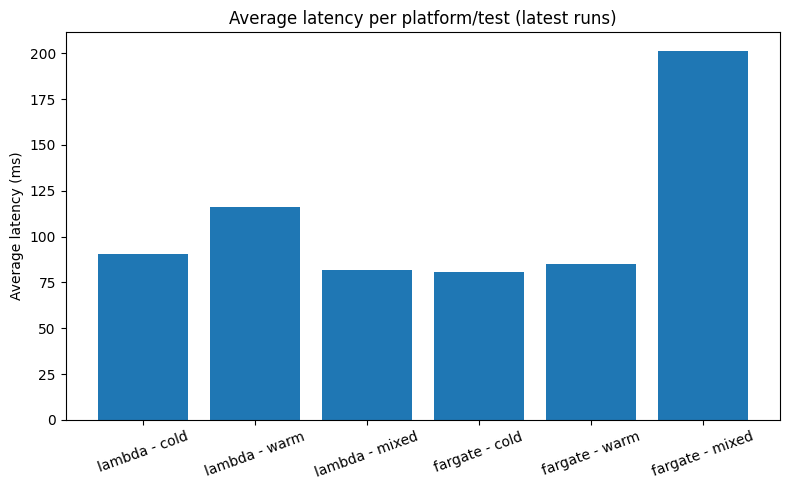

In [28]:
plt.figure(figsize=(8, 5))
plt.bar(summary_df["label"], summary_df["avg_ms"])
plt.ylabel("Average latency (ms)")
plt.title("Average latency per platform/test (latest runs)")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()


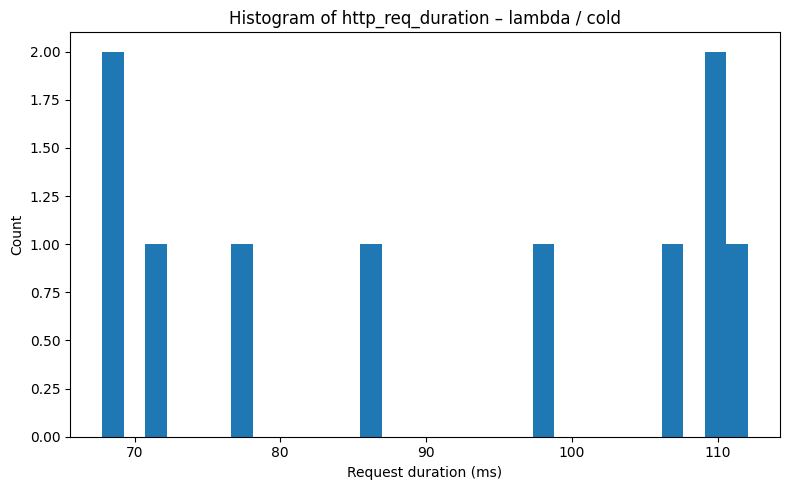

In [29]:
# pick one run to inspect
platform_to_view = "lambda"
test_to_view = "cold"

df_view = all_dfs.get((platform_to_view, test_to_view))
if df_view is None:
    raise ValueError(f"No dataset for {platform_to_view} / {test_to_view}")

durations = df_view[df_view["metric"] == "http_req_duration"]["value"]

plt.figure(figsize=(8, 5))
plt.hist(durations, bins=30)
plt.xlabel("Request duration (ms)")
plt.ylabel("Count")
plt.title(f"Histogram of http_req_duration – {platform_to_view} / {test_to_view}")
plt.tight_layout()
plt.show()


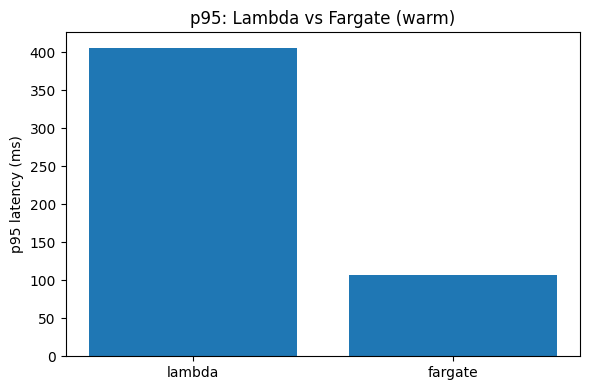

In [30]:
only_warm = summary_df[summary_df["test_type"] == "warm"].copy()

plt.figure(figsize=(6, 4))
plt.bar(only_warm["platform"], only_warm["p95_ms"])
plt.ylabel("p95 latency (ms)")
plt.title("p95: Lambda vs Fargate (warm)")
plt.tight_layout()
plt.show()


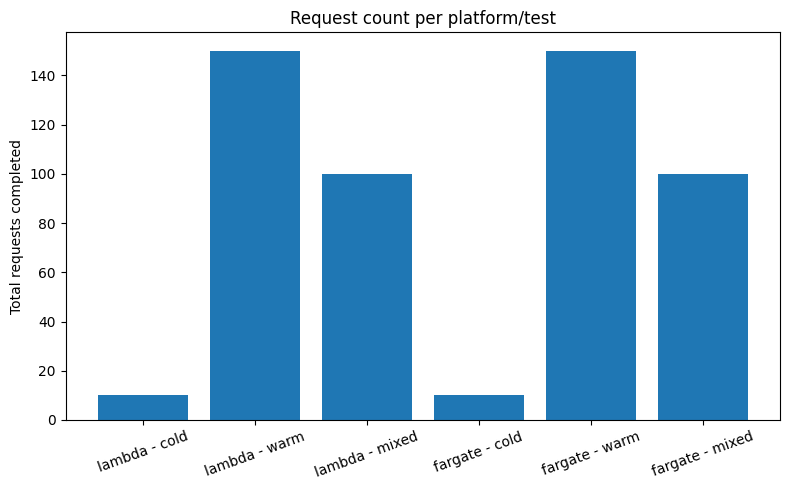

In [32]:
plt.figure(figsize=(8, 5))
plt.bar(throughput_df["platform"] + " - " + throughput_df["test_type"], throughput_df["requests"])
plt.ylabel("Total requests completed")
plt.title("Request count per platform/test")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()


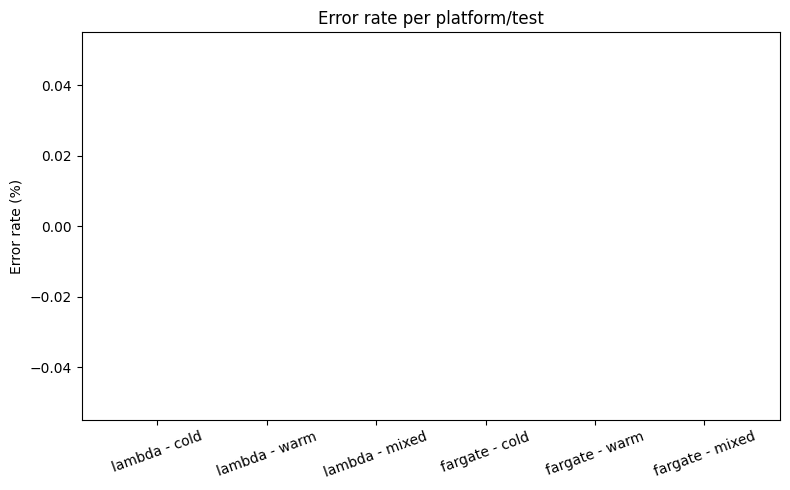

In [33]:
error_records = []
for (plat, test), df in all_dfs.items():
    total = len(df[df["metric"] == "http_req_duration"])
    failed = df[(df["metric"] == "http_req_failed") & (df["value"] == 1)].shape[0]
    error_rate = (failed / total) * 100 if total > 0 else 0
    error_records.append({
        "platform": plat,
        "test_type": test,
        "error_rate_%": error_rate
    })

error_df = pd.DataFrame(error_records)
plt.figure(figsize=(8,5))
plt.bar(error_df["platform"] + " - " + error_df["test_type"], error_df["error_rate_%"])
plt.ylabel("Error rate (%)")
plt.title("Error rate per platform/test")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()


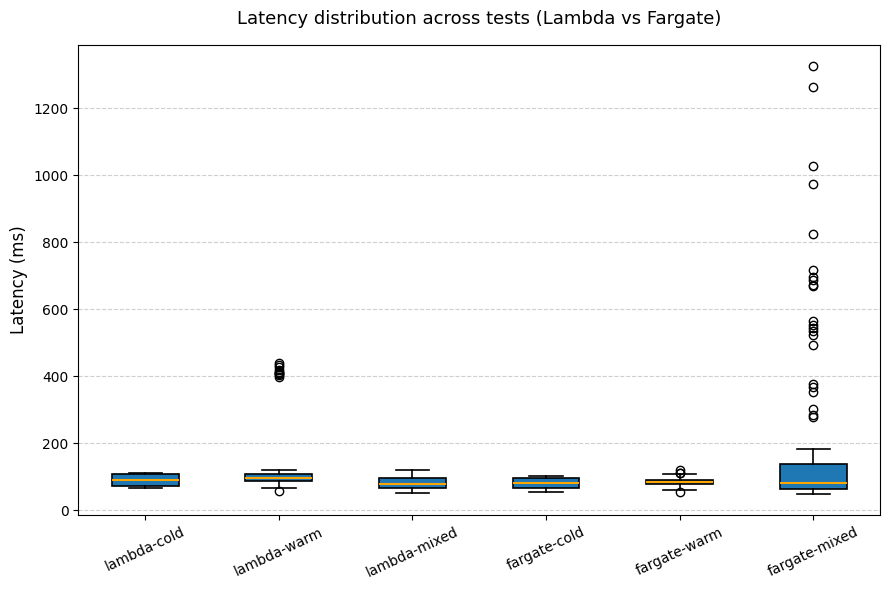

In [48]:
plt.figure(figsize=(9,6))

data_to_plot = []
labels = []

for (plat, test), df in all_dfs.items():
    vals = df[df["metric"] == "http_req_duration"]["value"]
    if len(vals) > 0:
        data_to_plot.append(vals)
        labels.append(f"{plat}-{test}")

boxprops = dict(linewidth=1.2, color="black")
medianprops = dict(linewidth=1.5, color="orange")
whiskerprops = dict(linewidth=1.2, color="black")
capprops = dict(linewidth=1.2, color="black")

plt.boxplot(
    data_to_plot,
    tick_labels=labels,
    vert=True,
    patch_artist=True,  # adds subtle background color
    boxprops=boxprops,
    medianprops=medianprops,
    whiskerprops=whiskerprops,
    capprops=capprops,
)

plt.xticks(rotation=25, fontsize=10)
plt.ylabel("Latency (ms)", fontsize=12)
plt.title("Latency distribution across tests (Lambda vs Fargate)", fontsize=13, pad=15)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


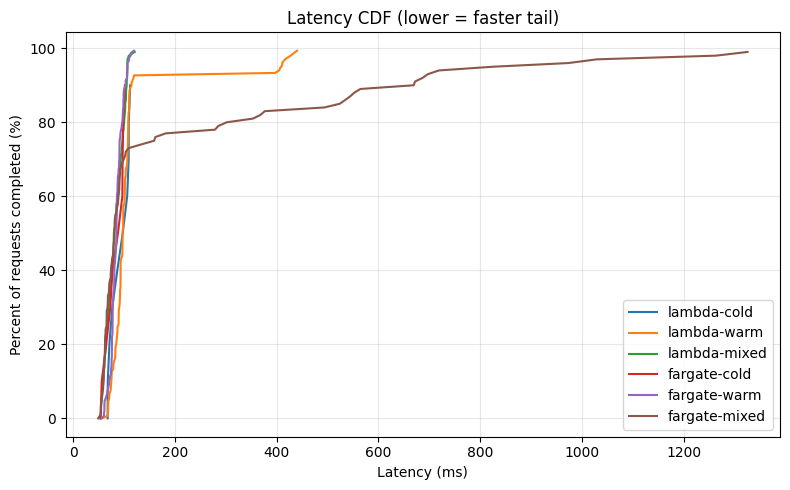

In [42]:
#import numpy as np

plt.figure(figsize=(8,5))

for (plat, test), df in all_dfs.items():
    d = df[df["metric"] == "http_req_duration"]["value"].sort_values()
    if len(d) == 0:
        continue
    y = (np.arange(len(d)) / len(d)) * 100
    plt.plot(d, y, label=f"{plat}-{test}")

plt.xlabel("Latency (ms)")
plt.ylabel("Percent of requests completed (%)")
plt.title("Latency CDF (lower = faster tail)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


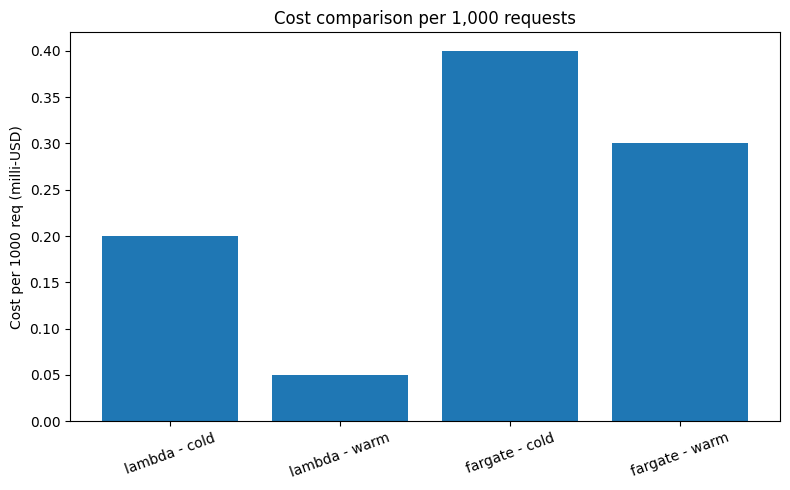

In [43]:
cost_data = pd.DataFrame([
    {"platform": "lambda", "test_type": "cold", "cost_per_1000_req": 0.0002},
    {"platform": "lambda", "test_type": "warm", "cost_per_1000_req": 0.00005},
    {"platform": "fargate", "test_type": "cold", "cost_per_1000_req": 0.0004},
    {"platform": "fargate", "test_type": "warm", "cost_per_1000_req": 0.0003},
])

plt.figure(figsize=(8,5))
plt.bar(cost_data["platform"] + " - " + cost_data["test_type"], cost_data["cost_per_1000_req"]*1000)
plt.ylabel("Cost per 1000 req (milli-USD)")
plt.title("Cost comparison per 1,000 requests")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()


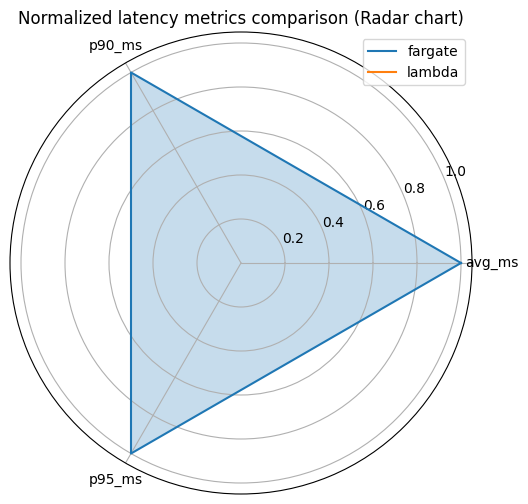

In [46]:
import numpy as np

# prepare normalized scores for 2 platforms (avg of warm runs)
def normalize(x):
    return (x - x.min()) / (x.max() - x.min())

metrics = summary_df.groupby("platform").agg({"avg_ms": "mean", "p90_ms": "mean", "p95_ms": "mean"}).reset_index()
metrics[["avg_ms", "p90_ms", "p95_ms"]] = metrics[["avg_ms", "p90_ms", "p95_ms"]].apply(normalize)

labels = ["avg_ms", "p90_ms", "p95_ms"]
angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False).tolist()
angles += angles[:1]

fig = plt.figure(figsize=(6,6))
ax = plt.subplot(111, polar=True)

for i, row in metrics.iterrows():
    values = row[labels].tolist()
    values += values[:1]
    ax.plot(angles, values, label=row["platform"])
    ax.fill(angles, values, alpha=0.25)

ax.set_thetagrids(np.degrees(angles[:-1]), labels)
plt.title("Normalized latency metrics comparison (Radar chart)")
plt.legend()
plt.show()


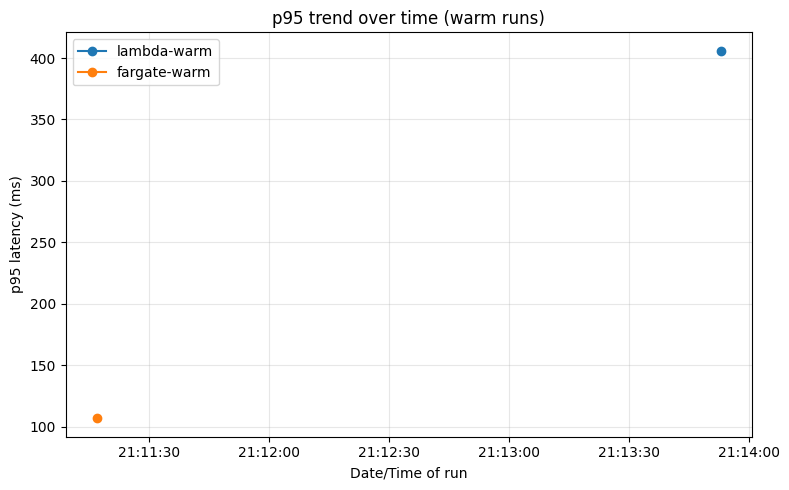

In [40]:
trend_records = []
for plat in PLATFORMS:
    runs = list_runs(plat)
    for r in runs:
        df = load_k6_json(r["path"])
        d = df[df["metric"] == "http_req_duration"]["value"]
        if len(d) > 0:
            trend_records.append({
                "platform": plat,
                "test_type": r["test_type"],
                "datetime": r["datetime"],
                "avg_ms": d.mean(),
                "p95_ms": d.quantile(0.95),
            })

trend_df = pd.DataFrame(trend_records)

plt.figure(figsize=(8,5))
for plat in trend_df["platform"].unique():
    subset = trend_df[(trend_df["platform"] == plat) & (trend_df["test_type"] == "warm")]
    plt.plot(subset["datetime"], subset["p95_ms"], marker="o", label=f"{plat}-warm")

plt.xlabel("Date/Time of run")
plt.ylabel("p95 latency (ms)")
plt.title("p95 trend over time (warm runs)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
